# An example plan

## Dependencies

In [1]:
from matplotlib import pylab as plt
from matplotlib import patches as mpl_patches
from matplotlib import cm

In [2]:
!pip3 install pysolar

     |████████████████████████████████| 47 kB 1.3 MB/s eta 0:00:011


In [3]:
from pysolar import solar
import datetime
import math
import numpy as np

In [4]:
site_location = [47.5249739, 18.7679596]
time_of_interest = datetime.datetime(2022, 4, 1, 8, 0, tzinfo=datetime.timezone.utc)

In [5]:
SUN_ALT = solar.get_altitude(site_location[0], site_location[1], time_of_interest)
SUN_ALT

33.906604560586686

In [6]:
for tt in range(6, 21):
    a = solar.get_altitude(site_location[0], site_location[1], datetime.datetime(2022, 4, 1, tt, 0, tzinfo=datetime.timezone.utc))
    print(a)

15.373967781765947
25.074292572563493
33.906604560586686
41.145958291762156
45.83618476632536
47.04641627755568
44.480423235750756
38.739677813196785
30.824094723729317
21.613541203103082
11.754434523081006
1.8819448762421631
-8.348123335792396
-17.68518103729883
-25.944611756433503


In [7]:
SUN_AZY = solar.get_azimuth(site_location[0], site_location[1], time_of_interest)
SUN_AZY

126.23981614645456

In [8]:
for tt in range(6, 21):
    az = solar.get_azimuth(site_location[0], site_location[1], datetime.datetime(2022, 4, 1, tt, 0, tzinfo=datetime.timezone.utc))
    print(az)

100.22337246807474
112.35231972435706
126.23981614645456
142.7836747632499
162.4164405107819
184.1107466518796
205.29192373836975
223.81411707155814
239.29623462224424
252.44106840056145
264.16099683897767
275.2724786109129
286.49111122160986
298.4928616350066
311.93790544194803


In [9]:
2/math.tan(math.radians(SUN_ALT))

2.9755730111612073

In [10]:
for h in range(5, 40, 5):
    print(1/math.tan(math.radians(h)))

11.430052302761343
5.671281819617709
3.7320508075688776
2.7474774194546225
2.1445069205095586
1.7320508075688774
1.4281480067421146


In [11]:
SUN_ROT = -45

## Define artist objects

In [12]:
'time_of_interest' in globals()

True

In [13]:
class Rectangle:
# A most basic artist, a rectangle that will also be building block of other objects   

    def __init__(
        self, width, height, angle=0, color="k", ls="-", lw=0.1,
        fill=False, alpha=1, z=2, sun_h=None, sun_a=None, sun_r=None,
        shadow_color="#D3D3D3", shadow_only=False
    ):
        self.x = 0
        self.y = 0
        self.z = z
        self.w = width
        self.h = height
        self.angle = angle
        self.color = color
        self.ls = ls
        self.lw = lw
        self.fill = fill
        self.alpha = alpha
        self.shadow_color = shadow_color
        self.shadow_only = shadow_only
        if sun_h is None:
            if 'SUN_ALT' in globals():
                self.sun_h = SUN_ALT
            else:
                self.sun_h = 20
        else:
            self.sun_h = sun_h
        self.sun_tn = self.z/math.tan(math.radians(SUN_ALT))
        if sun_r is None:
            if 'SUN_ROT' in globals():
                self.sun_r = SUN_ROT
            else:
                self.sun_r = 20
        else:
            self.sun_r = sun_r
        if sun_a is None:
            if 'SUN_AZY' in globals():
                self.sun_a = SUN_AZY + self.sun_r
            else:
                self.sun_a = 20
        else:
            self.sun_a = sun_a
    
    def update_positions(self, x, y):
        self.x = x
        self.y = y
    
    def rotate_edge(self, points, origin, angle):
        points = complex(*points)
        origin = complex(*origin)
        angle = np.deg2rad(angle)
        r = (points - origin) * np.exp(complex(0, angle)) + origin
        return (r.real, r.imag)
    
    def initialize_geometry(self):
        p = mpl_patches.Rectangle(
            (self.x, self.y), self.w, self.h, angle=self.angle, color=self.color,
            ls=self.ls, lw=self.lw, fill=self.fill, alpha = self.alpha
        )
        return p

    def initialize_shadow(self):
        p1 = mpl_patches.Polygon(
            [
                (self.x, self.y+self.h),
                (self.x+self.w, self.y+self.h),
                self.rotate_edge((self.x+self.w, self.y+self.h+self.sun_tn), (self.x+self.w, self.y+self.h), self.sun_a),
                self.rotate_edge((self.x, self.y+self.h+self.sun_tn), (self.x, self.y+self.h), self.sun_a)
            ],
            color=self.shadow_color, fill=True, alpha=0.1
        )
        p2 = mpl_patches.Polygon(
            [
                (self.x+self.w, self.y+self.h),
                (self.x+self.w, self.y),
                self.rotate_edge((self.x+self.w, self.y+self.sun_tn), (self.x+self.w, self.y), self.sun_a),
                self.rotate_edge((self.x+self.w, self.y+self.h+self.sun_tn), (self.x+self.w, self.y+self.h), self.sun_a)
            ],
            color=self.shadow_color, fill=True, alpha=0.1
        )
        p3 = mpl_patches.Polygon(
            [
                (self.x+self.w, self.y),
                (self.x, self.y),
                self.rotate_edge((self.x, self.y+self.sun_tn), (self.x, self.y), self.sun_a),
                self.rotate_edge((self.x+self.w, self.y+self.sun_tn), (self.x+self.w, self.y), self.sun_a)
            ],
            color=self.shadow_color, fill=True, alpha=0.1
        )
        p4 = mpl_patches.Polygon(
            [
                (self.x, self.y+self.h),
                (self.x, self.y),
                self.rotate_edge((self.x, self.y+self.sun_tn), (self.x, self.y), self.sun_a),
                self.rotate_edge((self.x, self.y+self.h+self.sun_tn), (self.x, self.y+self.h), self.sun_a)
            ],
            color=self.shadow_color, fill=True, alpha=0.1
        )
        return p1, p2, p3, p4

    def draw(self, ax):
        ax.add_patch(self.initialize_geometry())
        return ax

    def draw_shadowed(self, ax):
        for p in self.initialize_shadow():
            ax.add_patch(p)
        if not self.shadow_only:
            ax.add_patch(self.initialize_geometry())
        return ax

# Consider using something like https://lerner.co.il/2014/01/03/making-init-methods-magical-with-autoinit/ later

<AxesSubplot:>

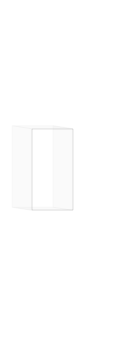

In [14]:
haz = Rectangle(6, 12)

fig, ax = plt.subplots(figsize=(2, 6))

ax.set_aspect("equal", adjustable="datalim")
ax.axis('off')
ax.plot([0, 12],[-0.5, -0.5], color="white")

haz.draw_shadowed(ax)

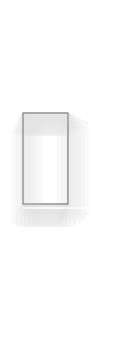

In [15]:
fig, ax = plt.subplots(figsize=(2, 6))

ax.set_aspect("equal", adjustable="datalim")
ax.axis('off')
ax.plot([0, 12],[-0.5, -0.5], color="white")

for tt in range(5, 13):
    a = solar.get_altitude(site_location[0], site_location[1], datetime.datetime(2022, 1, 1, tt, 0, tzinfo=datetime.timezone.utc))
    az = solar.get_azimuth(site_location[0], site_location[1], datetime.datetime(2022, 1, 1, tt, 0, tzinfo=datetime.timezone.utc))
    Rectangle(6, 12, sun_h=a, sun_a=az+45).draw_shadowed(ax)

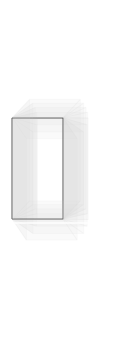

In [16]:
fig, ax = plt.subplots(figsize=(2, 6))

ax.set_aspect("equal", adjustable="datalim")
ax.axis('off')
ax.plot([0, 12],[-0.5, -0.5], color="white")

for tt in range(11, 19):
    a = solar.get_altitude(site_location[0], site_location[1], datetime.datetime(2022, 4, 1, tt, 0, tzinfo=datetime.timezone.utc))
    az = solar.get_azimuth(site_location[0], site_location[1], datetime.datetime(2022, 4, 1, tt, 0, tzinfo=datetime.timezone.utc))
    Rectangle(6, 12, sun_h=a, sun_a=az+30).draw_shadowed(ax)

In [17]:
class Ellipse(Rectangle):
# A primitive artist, an empty ellipse 

    def initialize_geometry(self):
        p = mpl_patches.Ellipse(
            (self.x, self.y), self.w, self.h, angle=self.angle, color=self.color,
            lw=self.lw, ls=self.ls, fill=self.fill, alpha = self.alpha
        )
        return p

In [18]:
class Circle(Rectangle):
# A primitive artist, an empty circle

    def __init__(
        self, r, angle=0, color="k", ls="-", lw=0.1,
        fill=False, alpha=1, z=2, sun_h=None, sun_a=None, sun_r=None,
        shadow_color="#D3D3D3", shadow_only=False
    ):
        self.x = 0
        self.y = 0
        self.z = z
        self.r = r
        self.color = color
        self.ls = ls
        self.lw = lw
        self.fill = fill
        self.shadow_color = shadow_color
        self.shadow_only = shadow_only
        if sun_h is None:
            if 'SUN_ALT' in globals():
                self.sun_h = SUN_ALT
            else:
                self.sun_h = 20
        else:
            self.sun_h = sun_h
        self.sun_tn = self.z/math.tan(math.radians(SUN_ALT))
        if sun_r is None:
            if 'SUN_ROT' in globals():
                self.sun_r = SUN_ROT
            else:
                self.sun_r = 20
        else:
            self.sun_r = sun_r
        if sun_a is None:
            if 'SUN_AZY' in globals():
                self.sun_a = SUN_AZY + self.sun_r
            else:
                self.sun_a = 20
        else:
            self.sun_a = sun_a      

    def initialize_geometry(self):
        p = mpl_patches.Circle(
            (self.x, self.y), self.r,
            color=self.color, ls=self.ls, fill=self.fill, lw=self.lw
        )
        return p

    def initialize_shadow(self):
        p1 = mpl_patches.Polygon(
            [
                (self.x-self.r, self.y+self.r),
                (self.x+self.r, self.y+self.r),
                self.rotate_edge((self.x+self.r, self.y+self.r+self.sun_tn), (self.x+self.r, self.y+self.r), self.sun_a),
                self.rotate_edge((self.x-self.r, self.y+self.r+self.sun_tn), (self.x-self.r, self.y+self.r), self.sun_a)
            ],
            color=self.shadow_color, fill=True, alpha=0.1
        )
        p2 = mpl_patches.Polygon(
            [
                (self.x+self.r, self.y+self.r),
                (self.x+self.r, self.y-self.r),
                self.rotate_edge((self.x+self.r, self.y+self.sun_tn-self.r), (self.x+self.r, self.y-self.r), self.sun_a),
                self.rotate_edge((self.x+self.r, self.y+self.r+self.sun_tn), (self.x+self.r, self.y+self.r), self.sun_a)
            ],
            color=self.shadow_color, fill=True, alpha=0.1
        )
        p3 = mpl_patches.Polygon(
            [
                (self.x+self.r, self.y-self.r),
                (self.x-self.r, self.y-self.r),
                self.rotate_edge((self.x-self.r, self.y+self.sun_tn-self.r), (self.x-self.r, self.y-self.r), self.sun_a),
                self.rotate_edge((self.x+self.r, self.y+self.sun_tn-self.r), (self.x+self.r, self.y-self.r), self.sun_a)
            ],
            color=self.shadow_color, fill=True, alpha=0.1
        )
        p4 = mpl_patches.Polygon(
            [
                (self.x-self.r, self.y+self.r),
                (self.x-self.r, self.y-self.r),
                self.rotate_edge((self.x-self.r, self.y+self.sun_tn-self.r), (self.x-self.r, self.y-self.r), self.sun_a),
                self.rotate_edge((self.x-self.r, self.y+self.r+self.sun_tn), (self.x-self.r, self.y+self.r), self.sun_a)
            ],
            color=self.shadow_color, fill=True, alpha=0.1
        )
        return p1, p2, p3, p4

In [19]:
class Wedge(Rectangle):
# A primitive artist, a half circle

    def __init__(self, r, t1=0, t2=180, color="k", ls="-", lw=0.1, fill=False):
        self.x = 0
        self.y = 0
        self.r = r
        self.t1 = t1
        self.t2 = t2
        self.color = color
        self.ls = ls
        self.lw = lw
        self.fill = fill        

    def initialize_geometry(self):
        p = mpl_patches.Wedge(
            (self.x, self.y), self.r, self.t1, self.t2,
            color=self.color, ls=self.ls, fill=self.fill, lw=self.lw
        )
        return p

In [20]:
class Polygon(Rectangle):
# A primitive artist, a custom polygon

    def __init__(
        self, point_aray, color="k", ls="-", lw=0.1,
        fill=False, alpha=1, z=2, sun_h=None, sun_a=None, sun_r=None,
        shadow_color="#D3D3D3", shadow_only=False
    ):
        self.points_original = point_aray
        self.points = point_aray
        self.z = z
        self.color = color
        self.ls = ls
        self.lw = lw
        self.fill = fill
        self.alpha = alpha
        self.shadow_color = shadow_color
        self.shadow_only = shadow_only
        if sun_h is None:
            if 'SUN_ALT' in globals():
                self.sun_h = SUN_ALT
            else:
                self.sun_h = 20
        else:
            self.sun_h = sun_h
        self.sun_tn = self.z/math.tan(math.radians(SUN_ALT))
        if sun_r is None:
            if 'SUN_ROT' in globals():
                self.sun_r = SUN_ROT
            else:
                self.sun_r = 20
        else:
            self.sun_r = sun_r
        if sun_a is None:
            if 'SUN_AZY' in globals():
                self.sun_a = SUN_AZY + self.sun_r
            else:
                self.sun_a = 20
        else:
            self.sun_a = sun_a 
    
    def update_positions(self, x, y):
        self.points =  [(dx+x, dy+y) for dx, dy in self.points_original]  

    def initialize_geometry(self):
        p = mpl_patches.Polygon(
            self.points, color=self.color, ls=self.ls, lw=self.lw,
            fill=self.fill, alpha = self.alpha
        )
        return p
    
    def initialize_shadow(self):
        pl = []
        for i, (xp1, yp1) in enumerate(self.points):
            xp2, yp2 = self.points[i-1]
            p = mpl_patches.Polygon(
                [
                    (xp1, yp1), (xp2, yp2),
                    self.rotate_edge((xp2, yp2+self.sun_tn), (xp2, yp2), self.sun_a),
                    self.rotate_edge((xp1, yp1+self.sun_tn), (xp1, yp1), self.sun_a)
                ],
                color=self.shadow_color, fill=True, alpha=0.1
            )
            pl.append(p)
        return pl

In [21]:
class CustomPlatform(Polygon):
# A composite object built up of multiple primitves

    def __init__(self, color="k", ls="-", lw=0.1, fill=False, szines=False):
        self.color = color
        self.ls = ls
        self.lw = lw
        self.fill = fill
        self.points_original = [
            (0.2, 0.2),
            (2.9, 0.2),
            (0, 0),
            (0, 5),
            (6, 5),
            (6, 0),
            (2.7, 0),
            (2.7, 1.2),
            (1.2, 1.2),
            (1.2, 0),
            (1.2, 0.3),
            (2.7, 0.3),
            (2.7, 0.6),
            (1.2, 0.6),
            (1.2, 0.9),
            (2.7, 0.9),
            (2.7, 0)
        ]
        self.points = self.points_original
        if szines:
            self.grasscolor = "#8FBC8F"
        else:
            self.grasscolor = self.color
        if szines:
            self.grassfill = True
        else:
            self.grassfill = self.fill
    
    def update_positions(self, x, y):
        self.points =  [(dx+x, dy+y) for dx, dy in self.points_original]  

    def initialize_geometry(self):
        p = mpl_patches.Polygon(
            self.points[2:],
            color=self.color, ls=self.ls, fill=self.fill, lw=self.lw
        )
        s1 = mpl_patches.Rectangle(
            self.points[0], 0.8, 0.8,
            color=self.grasscolor, ls=self.ls, fill=self.grassfill, lw=self.lw
        )
        s2 = mpl_patches.Rectangle(
            self.points[1], 0.8, 0.8,
            color=self.grasscolor, ls=self.ls, fill=self.grassfill, lw=self.lw
        )
        return p, s1, s2

    def draw(self, ax):
        for p in self.initialize_geometry():
            ax.add_patch(p)
        return ax

## Dimensions and locations

In [22]:
object_collection = dict(
    telek = Polygon([(0, 0), (14, 4), (14, 39), (0, 39)]),
    haz = Rectangle(6, 12),
    tornac = Rectangle(1, 7),
    lepcso = Polygon([(0, 0), (1, 0), (1, 2.8), (0, 2.8), (0, 2.5), (1, 2.5), (1, 2.2), (0, 2.2), (0, 1.9), (1, 1.9), (1, 0.9), (0, 0.9), (0, 0.6), (1, 0.6), (1, 0.3), (0, 0.3)]),
    terasz = CustomPlatform(),
    tarolo = Rectangle(2, 1.5),
    # pavilon = Rectangle(4, 5),
    pavilon = Polygon([(0, 1.5), (0, 4), (4, 4), (4, 0), (1.5, 0)]),
    pavilon2 = Polygon([(0, 0), (4, 0), (4, 1.5), (1.5, 1.5)], ls=":"),
    kocsi_elol = Rectangle(4, 5),
    kocsi_hatul = Polygon([(0, 0), (0, 5), (4, 5), (4, 1)]),
    platform1 = Rectangle(2, 2, color="red"),
    platform2 = Rectangle(2, 2, color="red"),
    magasagyas1 = Rectangle(1, 1),
    magasagyas2 = Rectangle(1, 1),
    magasagyas3 = Rectangle(1, 1),
    magasagyas4 = Rectangle(0.5, 2),
    diszagyas = Wedge(2, 90, -90),
    kisdisz = Circle(1),
    fenyo = Circle(1),
    mandula = Circle(1),
    gyumolcs1 = Circle(1),
    gyumolcs2 = Circle(1),
    gyumolcs3 = Circle(1),
    gyep = Ellipse(16, 8, angle=60),
    jatekos = Rectangle(1.5, 3, angle=60)
)

In [23]:
object_locations = dict(
    telek = (0, 0),
    haz = (1, 24),
    tornac = (6, 29),
    lepcso = (7, 31),
    terasz = (1, 19),
    tarolo = (12, 34.5),
    pavilon = (10, 24),
    pavilon2 = (10, 28),
    kocsi_elol = (8, 34),
    kocsi_hatul = (10, 3),
    platform1 = (11, 10),
    platform2 = (11, 13),
    magasagyas1 = (13, 10),
    magasagyas2 = (13, 12),
    magasagyas3 = (13, 14),
    magasagyas4 = (0.5, 16),
    diszagyas = (14, 32.5),
    kisdisz = (12.5, 32.5),
    fenyo = (4, 37.5),
    mandula = (6, 12),
    gyep = (7, 12),
    jatekos = (3, 3),
    gyumolcs1 = (1.4, 2.1),
    gyumolcs2 = (4.4, 3.1),
    gyumolcs3 = (7.4, 4.1)
)

## Draw plan

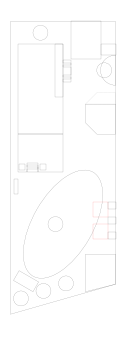

In [24]:
for k, v in object_locations.items():
    object_collection[k].update_positions(*v)

fig, ax = plt.subplots(figsize=(2, 6))

ax.set_aspect("equal", adjustable="datalim")
ax.axis('off')
ax.plot([0, 12],[-0.5, -0.5], color="white")

for k, v in object_collection.items():
    v.draw(ax)

fig.savefig("tervek/terv_fekete_feher.pdf")

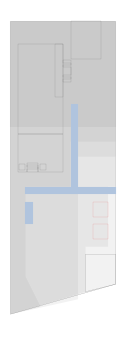

In [40]:
Vcolors = cm.gray(np.linspace(0, 1, 5))

object_collection = dict(
    telek = Polygon([(0, 0), (14, 4), (14, 39), (0, 39)]),
    haz = Rectangle(6, 12),
    tornac = Rectangle(1, 7),
    lepcso = Polygon([(0, 0), (1, 0), (1, 2.8), (0, 2.8), (0, 2.5), (1, 2.5), (1, 2.2), (0, 2.2), (0, 1.9), (1, 1.9), (1, 0.9), (0, 0.9), (0, 0.6), (1, 0.6), (1, 0.3), (0, 0.3)]),
    terasz = CustomPlatform(),
    kocsi_elol = Rectangle(4, 5),
    kocsi_hatul = Polygon([(0, 0), (0, 5), (4, 5), (4, 1)]),
    platform1 = Rectangle(2, 2, color="red"),
    platform2 = Rectangle(2, 2, color="red"),
    szint1 = Polygon([(0, 0), (14, 4), (14, 39), (0, 39)], color="grey", alpha=0.1, fill=True),
    szint2 = Polygon([(0, 0), (10, 3), (10, 9), (13, 9), (13, 17), (14, 17), (14, 39), (0, 39)], color="grey", alpha=0.1, fill=True),
    szint3 = Polygon([(0, 0), (9, 2), (9, 21), (14, 21), (14, 39), (0, 39)], color="grey", alpha=0.1, fill=True),
    szint4 = Polygon([(0, 0), (4, 1), (2, 5), (2, 17), (8, 17), (8, 23), (14, 23), (14, 39), (0, 39)], color="grey", alpha=0.1, fill=True),
    szint5 = Polygon([(0, 0), (14, 0), (14, 14), (0, 14)], color="grey", alpha=0.1, fill=True),
    ut1 =  Rectangle(1, 12, color="#b0c4de", fill=True),
    ut2 =  Rectangle(12, 1, color="#b0c4de", fill=True),
    ut3 =  Rectangle(1, 3, color="#b0c4de", fill=True),
)

object_locations = dict(
    telek = (0, 0),
    haz = (1, 24),
    tornac = (6, 29),
    lepcso = (7, 31),
    terasz = (1, 19),
    kocsi_elol = (8, 34),
    kocsi_hatul = (10, 3),
    platform1 = (11, 10),
    platform2 = (11, 13),
    szint1 =(0, 0),
    szint2 =(0, 0),
    szint3 =(0, 0),
    szint4 =(0, 0),
    szint5 =(0, 25)
)

for k, v in object_locations.items():
    object_collection[k].update_positions(*v)

fig, ax = plt.subplots(figsize=(2, 6))

ax.set_aspect("equal", adjustable="datalim")
ax.axis('off')
ax.plot([0, 12],[-0.5, -0.5], color="white")

for k, v in object_collection.items():
    v.draw(ax)

fig.savefig("tervek/szintezett_terv.pdf")

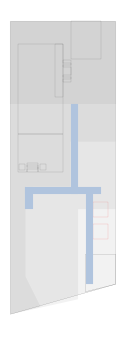

In [45]:
Vcolors = cm.gray(np.linspace(0, 1, 5))

object_collection = dict(
    telek = Polygon([(0, 0), (14, 4), (14, 39), (0, 39)]),
    haz = Rectangle(6, 12),
    tornac = Rectangle(1, 7),
    lepcso = Polygon([(0, 0), (1, 0), (1, 2.8), (0, 2.8), (0, 2.5), (1, 2.5), (1, 2.2), (0, 2.2), (0, 1.9), (1, 1.9), (1, 0.9), (0, 0.9), (0, 0.6), (1, 0.6), (1, 0.3), (0, 0.3)]),
    terasz = CustomPlatform(),
    kocsi_elol = Rectangle(4, 5),
    kocsi_hatul = Polygon([(0, 0), (0, 5), (4, 5), (4, 1)]),
    platform1 = Rectangle(2, 2, color="red"),
    platform2 = Rectangle(2, 2, color="red"),
    szint1 = Polygon([(0, 0), (14, 4), (14, 39), (0, 39)], color="grey", alpha=0.1, fill=True),
    #szint2 = Polygon([(0, 0), (10, 3), (10, 9), (13, 9), (13, 17), (14, 17), (14, 39), (0, 39)], color="grey", alpha=0.1, fill=True),
    szint3 = Polygon([(0, 0), (9, 2), (9, 14), (14, 14), (14, 39), (0, 39)], color="grey", alpha=0.1, fill=True),
    szint4 = Polygon([(0, 0), (4, 1), (2, 5), (2, 17), (8, 17), (8, 23), (14, 23), (14, 39), (0, 39)], color="grey", alpha=0.1, fill=True),
    szint5 = Polygon([(0, 0), (14, 0), (14, 11), (0, 11)], color="grey", alpha=0.1, fill=True),
    ut1 =  Rectangle(1, 12, color="#b0c4de", fill=True),
    ut2 =  Rectangle(10, 1, color="#b0c4de", fill=True),
    ut3 =  Rectangle(1, 3, color="#b0c4de", fill=True),
    ut4 =  Rectangle(1, 12, color="#b0c4de", fill=True)
)

object_locations = dict(
    telek = (0, 0),
    haz = (1, 24),
    tornac = (6, 29),
    lepcso = (7, 31),
    terasz = (1, 19),
    kocsi_elol = (8, 34),
    kocsi_hatul = (10, 3),
    platform1 = (11, 10),
    platform2 = (11, 13),
    szint1 =(0, 0),
    #szint2 =(0, 0),
    szint3 =(0, 0),
    szint4 =(0, 0),
    szint5 =(0, 28),
    ut1 =(8, 16),
    ut2 =(2, 16),
    ut3 =(2, 14),
    ut4 =(10, 4)
)

for k, v in object_locations.items():
    object_collection[k].update_positions(*v)

fig, ax = plt.subplots(figsize=(2, 6))

ax.set_aspect("equal", adjustable="datalim")
ax.axis('off')
ax.plot([0, 12],[-0.5, -0.5], color="white")

for k, v in object_collection.items():
    v.draw(ax)

fig.savefig("tervek/szintezett_terv2.pdf")

## Draw shadows

In [22]:
shadow_collection = dict(
    haz_reggel = Polygon([(0, 6), (3, 0), (3, 10), (0, 12)], color="red", alpha=0.1, fill=True),
    haz_du = Polygon([(0, 0), (6, -3), (6, 9), (0, 12)], color="blue", alpha=0.1, fill=True),
    kerites_reggel = Polygon([(0, 0), (0, 1.5), (12, 5.5), (12, 29), (14, 27), (14, 4)], color="red", alpha=0.1, fill=True),
    kerites_du = Polygon([(0, 0), (2, 0.5), (2, 39), (0, 39)], color="blue", alpha=0.1, fill=True),
    mandula_reggel = Polygon([(0, 0), (0.5, 0), (-3, 5), (-5, 4)], color="red", alpha=0.1, fill=True),
    mandula_du = Polygon([(0, 0), (0.5, 0), (3, -6), (5, -6)], color="blue", alpha=0.1, fill=True)
)

shadow_locations = dict(
    haz_reggel = (11, 24),
    haz_du = (7, 24),
    kerites_reggel = (0, 0),
    kerites_du = (0, 0),
    mandula_reggel = (6, 12),
    mandula_du = (6, 12)
)

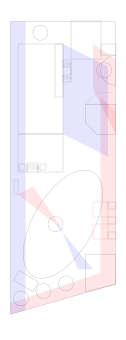

In [23]:
for k, v in object_locations.items():
    object_collection[k].update_positions(*v)

for k, v in shadow_locations.items():
    shadow_collection[k].update_positions(*v)

fig, ax = plt.subplots(figsize=(2, 6))

ax.set_aspect("equal", adjustable="datalim")
ax.axis('off')
ax.plot([0, 12],[-0.5, -0.5], color="white")

for k, v in object_collection.items():
    v.draw(ax)

for k, v in shadow_collection.items():
    v.draw(ax)
    
fig.savefig("tervek/arnyekok.pdf")

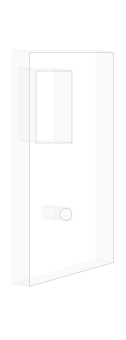

In [124]:
shadow_collection = dict(
    telek = Polygon([(0, 0), (14, 4), (14, 39), (0, 39)]),
    haz = Rectangle(6, 12),
    mandula = Circle(1)
    
)

shadow_locations = dict(
    haz = (1, 24),
    telek = (0, 0),
    mandula = (6, 12)
)

for k, v in shadow_locations.items():
    shadow_collection[k].update_positions(*v)

fig, ax = plt.subplots(figsize=(2, 6))

ax.set_aspect("equal", adjustable="datalim")
ax.axis('off')
ax.plot([0, 12],[-0.5, -0.5], color="white")

for k, v in shadow_collection.items():
    v.draw_shadowed(ax)

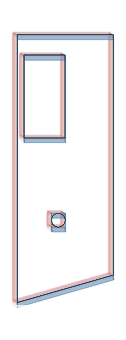

In [161]:
fig, ax = plt.subplots(figsize=(2, 6))

ax.set_aspect("equal", adjustable="datalim")
ax.axis('off')
ax.plot([0, 12],[-0.5, -0.5], color="white")

site_orientation = -70

hours_checked = range(5, 20)
Ncolors = len(hours_checked)
Vcolors = cm.RdBu(np.linspace(0, 1, Ncolors))

for i, tt in enumerate(hours_checked):
    a = solar.get_altitude(site_location[0], site_location[1], datetime.datetime(2022, 1, 1, tt, 0, tzinfo=datetime.timezone.utc))
    az = solar.get_azimuth(site_location[0], site_location[1], datetime.datetime(2022, 1, 1, tt, 0, tzinfo=datetime.timezone.utc))+site_orientation
    telek = Polygon([(0, 0), (14, 4), (14, 39), (0, 39)], sun_h=a, sun_a=az, shadow_color=Vcolors[i])
    telek.draw_shadowed(ax)
    haz = Rectangle(6, 12, sun_h=a, sun_a=az, shadow_color=Vcolors[i])
    haz.update_positions(x=1, y=24)
    haz.draw_shadowed(ax)
    fa = Circle(1, sun_h=a, sun_a=az, shadow_color=Vcolors[i])
    fa.update_positions(x=6, y=12)
    fa.draw_shadowed(ax)

fig.savefig("tervek/arnyekok_januar.pdf")

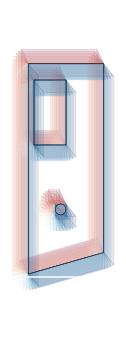

In [162]:
fig, ax = plt.subplots(figsize=(2, 6))

ax.set_aspect("equal", adjustable="datalim")
ax.axis('off')
ax.plot([0, 12],[-0.5, -0.5], color="white")

site_orientation = -70

hours_checked = range(5, 20)
Ncolors = len(hours_checked)
Vcolors = cm.RdBu(np.linspace(0, 1, Ncolors))

for i, tt in enumerate(hours_checked):
    a = solar.get_altitude(site_location[0], site_location[1], datetime.datetime(2022, 3, 1, tt, 0, tzinfo=datetime.timezone.utc))
    az = solar.get_azimuth(site_location[0], site_location[1], datetime.datetime(2022, 3, 1, tt, 0, tzinfo=datetime.timezone.utc))+site_orientation
    telek = Polygon([(0, 0), (14, 4), (14, 39), (0, 39)], sun_h=a, sun_a=az, shadow_color=Vcolors[i])
    telek.draw_shadowed(ax)
    haz = Rectangle(6, 12, sun_h=a, sun_a=az, shadow_color=Vcolors[i])
    haz.update_positions(x=1, y=24)
    haz.draw_shadowed(ax)
    fa = Circle(1, sun_h=a, sun_a=az, shadow_color=Vcolors[i])
    fa.update_positions(x=6, y=12)
    fa.draw_shadowed(ax)

fig.savefig("tervek/arnyekok_marcius.pdf")

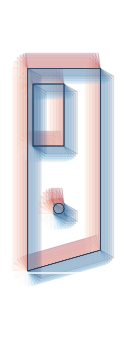

In [164]:
fig, ax = plt.subplots(figsize=(2, 6))

ax.set_aspect("equal", adjustable="datalim")
ax.axis('off')
ax.plot([0, 12],[-0.5, -0.5], color="white")

site_orientation = -70

hours_checked = range(5, 20)
Ncolors = len(hours_checked)
Vcolors = cm.RdBu(np.linspace(0, 1, Ncolors))

for i, tt in enumerate(hours_checked):
    a = solar.get_altitude(site_location[0], site_location[1], datetime.datetime(2022, 6, 1, tt, 0, tzinfo=datetime.timezone.utc))
    az = solar.get_azimuth(site_location[0], site_location[1], datetime.datetime(2022, 6, 1, tt, 0, tzinfo=datetime.timezone.utc))+site_orientation
    telek = Polygon([(0, 0), (14, 4), (14, 39), (0, 39)], sun_h=a, sun_a=az, shadow_color=Vcolors[i])
    telek.draw_shadowed(ax)
    haz = Rectangle(6, 12, sun_h=a, sun_a=az, shadow_color=Vcolors[i])
    haz.update_positions(x=1, y=24)
    haz.draw_shadowed(ax)
    fa = Circle(1, sun_h=a, sun_a=az, shadow_color=Vcolors[i])
    fa.update_positions(x=6, y=12)
    fa.draw_shadowed(ax)

fig.savefig("tervek/arnyekok_junius.pdf")

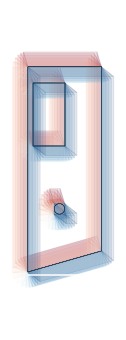

In [166]:
fig, ax = plt.subplots(figsize=(2, 6))

ax.set_aspect("equal", adjustable="datalim")
ax.axis('off')
ax.plot([0, 12],[-0.5, -0.5], color="white")

site_orientation = -70

hours_checked = range(5, 20)
Ncolors = len(hours_checked)
Vcolors = cm.RdBu(np.linspace(0, 1, Ncolors))

for i, tt in enumerate(hours_checked):
    a = solar.get_altitude(site_location[0], site_location[1], datetime.datetime(2022, 9, 1, tt, 0, tzinfo=datetime.timezone.utc))
    az = solar.get_azimuth(site_location[0], site_location[1], datetime.datetime(2022, 9, 1, tt, 0, tzinfo=datetime.timezone.utc))+site_orientation
    telek = Polygon([(0, 0), (14, 4), (14, 39), (0, 39)], sun_h=a, sun_a=az, shadow_color=Vcolors[i])
    telek.draw_shadowed(ax)
    haz = Rectangle(6, 12, sun_h=a, sun_a=az, shadow_color=Vcolors[i])
    haz.update_positions(x=1, y=24)
    haz.draw_shadowed(ax)
    fa = Circle(1, sun_h=a, sun_a=az, shadow_color=Vcolors[i])
    fa.update_positions(x=6, y=12)
    fa.draw_shadowed(ax)

fig.savefig("tervek/arnyekok_szeptember.pdf")

## Alernative plan

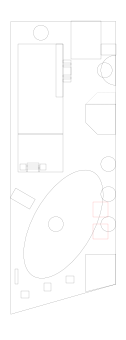

In [171]:
object_locations = dict(
    magasagyas1 = (1.4, 2.1),
    magasagyas2 = (4.4, 3.1),
    magasagyas3 = (7.4, 4.1),
    magasagyas4 = (0.5, 4),
    jatekos = (2.5, 14),
    gyumolcs1 = (13, 12),
    gyumolcs2 = (13, 16),
    gyumolcs3 = (13, 20)
)

for k, v in object_locations.items():
    object_collection[k].update_positions(*v)

fig, ax = plt.subplots(figsize=(2, 6))

ax.set_aspect("equal", adjustable="datalim")
ax.axis('off')
ax.plot([0, 12],[-0.5, -0.5], color="white")

for k, v in object_collection.items():
    v.draw(ax)

fig.savefig("tervek/alternativ_terv.pdf")

## Draw roads

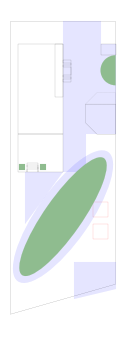

In [107]:
object_collection = dict(
    telek = Polygon([(0, 0), (14, 4), (14, 39), (0, 39)]),
    haz_elott = Rectangle(7, 12, color="blue", alpha=0.1, fill=True),
    haz = Rectangle(6, 12),
    tornac = Rectangle(1, 7),
    lepcso = Polygon([(0, 0), (1, 0), (1, 2.8), (0, 2.8), (0, 2.5), (1, 2.5), (1, 2.2), (0, 2.2), (0, 1.9), (1, 1.9), (1, 0.9), (0, 0.9), (0, 0.6), (1, 0.6), (1, 0.3), (0, 0.3)]),
    terasz = CustomPlatform(szines=True),
    tarolo = Rectangle(2, 1.5),
    pavilon = Polygon([(0, 1.5), (0, 4), (4, 4), (4, 0), (1.5, 0)]),
    pavilon2 = Polygon([(0, 0), (4, 0), (4, 1.5), (1.5, 1.5)], ls=":"),
    kocsi_elol = Rectangle(5, 3, color="blue", alpha=0.1, fill=True),
    kocsi_hatul = Polygon([(0, 0), (0, 5), (5.5, 5), (5.5, 1.3)], color="blue", alpha=0.1, fill=True),
    platform1 = Rectangle(2, 2, color="red"),
    platform2 = Rectangle(2, 2, color="red"),
    mandula = Circle(1),
    diszagyas = Wedge(2, 90, -90, color="#8FBC8F", fill=True),
    terasz_ut1 = Polygon([(0, 0), (0, 7), (5, 7)], color="blue", alpha=0.1, fill=True),
    terasz_ut2 = Polygon([(0, 0), (3, 0), (3, 5), (0, 5)], color="blue", alpha=0.1, fill=True),
    gyep_kint = Ellipse(21, 7, angle=55, color="blue", alpha=0.1, fill=True),
    gyep_bent = Ellipse(19, 5, angle=55, color="#8FBC8F", alpha=1, fill=True)
)

object_locations = dict(
    telek = (0, 0),
    haz = (1, 24),
    tornac = (6, 29),
    lepcso = (7, 31),
    terasz = (1, 19),
    tarolo = (12, 34.5),
    pavilon = (10, 24),
    pavilon2 = (10, 28),
    haz_elott = (7, 24),
    kocsi_elol = (7, 36),
    kocsi_hatul = (8.5, 2),
    platform1 = (11, 10),
    platform2 = (11, 13),
    mandula = (6, 12),
    diszagyas = (14, 32.5),
    terasz_ut1 = (2, 12),
    terasz_ut2 = (7, 19),
    gyep_kint = (7, 13),
    gyep_bent = (7, 13)
)

for k, v in object_locations.items():
    object_collection[k].update_positions(*v)

fig, ax = plt.subplots(figsize=(2, 6))

ax.set_aspect("equal", adjustable="datalim")
ax.axis('off')
ax.plot([0, 12],[-0.5, -0.5], color="white")

for k, v in object_collection.items():
    v.draw(ax)

fig.savefig("utak.pdf")

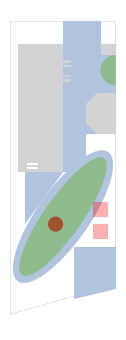

In [108]:
object_collection = dict(
    telek = Polygon([(0, 0), (14, 4), (14, 39), (0, 39)]),
    haz_elott = Rectangle(7, 12, color="#b0c4de", fill=True),
    haz = Rectangle(6, 12, color="#D3D3D3", fill=True),
    tornac = Rectangle(1, 7, color="#D3D3D3", fill=True),
    lepcso = Polygon([(0, 0), (1, 0), (1, 2.8), (0, 2.8), (0, 2.5), (1, 2.5), (1, 2.2), (0, 2.2), (0, 1.9), (1, 1.9), (1, 0.9), (0, 0.9), (0, 0.6), (1, 0.6), (1, 0.3), (0, 0.3)], color="#D3D3D3", fill=True),
    terasz = CustomPlatform(szines=True, color="#D3D3D3", fill=True),
    tarolo = Rectangle(2, 1.5, color="#D3D3D3", fill=True),
    pavilon = Polygon([(0, 1.5), (0, 4), (4, 4), (4, 0), (1.5, 0)], color="#D3D3D3", fill=True),
    pavilon2 = Polygon([(0, 0), (4, 0), (4, 1.5), (1.5, 1.5)], ls=":", color="#D3D3D3", fill=True),
    kocsi_elol = Rectangle(5, 3, color="#b0c4de", fill=True),
    kocsi_hatul = Polygon([(0, 0), (0, 7), (5.5, 7), (5.5, 1.3)], color="#b0c4de", fill=True),
    diszagyas = Wedge(2, 90, -90, color="#8FBC8F", fill=True),
    terasz_ut1 = Polygon([(0, 0), (0, 7), (5, 7)], color="#b0c4de", fill=True),
    terasz_ut2 = Polygon([(0, 0), (3, 0), (3, 5), (0, 5)], color="#b0c4de", fill=True),
    gyep_kint = Ellipse(21, 7, angle=55, color="#b0c4de", fill=True),
    gyep_bent = Ellipse(19, 5, angle=55, color="#8FBC8F", fill=True),
    mandula = Circle(1, color="#a0522d", fill=True),
    platform1 = Rectangle(2, 2, color="red", alpha=0.3, fill=True),
    platform2 = Rectangle(2, 2, color="red", alpha=0.3, fill=True)
)

object_locations = dict(
    telek = (0, 0),
    haz = (1, 24),
    tornac = (6, 29),
    lepcso = (7, 31),
    terasz = (1, 19),
    tarolo = (12, 34.5),
    pavilon = (10, 24),
    pavilon2 = (10, 28),
    haz_elott = (7, 24),
    kocsi_elol = (7, 36),
    kocsi_hatul = (8.5, 2),
    platform1 = (11, 10),
    platform2 = (11, 13),
    mandula = (6, 12),
    diszagyas = (14, 32.5),
    terasz_ut1 = (2, 12),
    terasz_ut2 = (7, 19),
    gyep_kint = (7, 13),
    gyep_bent = (7, 13)
)

for k, v in object_locations.items():
    object_collection[k].update_positions(*v)

fig, ax = plt.subplots(figsize=(2, 6))

ax.set_aspect("equal", adjustable="datalim")
ax.axis('off')
ax.plot([0, 12],[-0.5, -0.5], color="white")

for k, v in object_collection.items():
    v.draw(ax)

fig.savefig("tervek/utak.pdf")

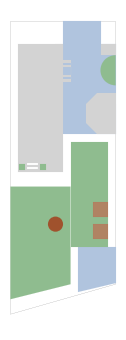

In [183]:
object_collection = dict(
    telek = Polygon([(0, 0), (14, 4), (14, 39), (0, 39)]),
    haz_elott = Rectangle(7, 12, color="#b0c4de", fill=True),
    haz = Rectangle(6, 12, color="#D3D3D3", fill=True),
    tornac = Rectangle(1, 7, color="#D3D3D3", fill=True),
    lepcso = Polygon([(0, 0), (1, 0), (1, 2.8), (0, 2.8), (0, 2.5), (1, 2.5), (1, 2.2), (0, 2.2), (0, 1.9), (1, 1.9), (1, 0.9), (0, 0.9), (0, 0.6), (1, 0.6), (1, 0.3), (0, 0.3)], color="#D3D3D3", fill=True),
    terasz = CustomPlatform(szines=True, color="#D3D3D3", fill=True),
    tarolo = Rectangle(2, 1.5, color="#D3D3D3", fill=True),
    pavilon = Polygon([(0, 1.5), (0, 4), (4, 4), (4, 0), (1.5, 0)], color="#D3D3D3", fill=True),
    pavilon2 = Polygon([(0, 0), (4, 0), (4, 1.5), (1.5, 1.5)], ls=":", color="#D3D3D3", fill=True),
    kocsi_elol = Rectangle(5, 3, color="#b0c4de", fill=True),
    kocsi_hatul = Polygon([(0, 0), (0, 6), (5, 6), (5, 1.2)], color="#b0c4de", fill=True),
    diszagyas = Wedge(2, 90, -90, color="#8FBC8F", fill=True),
    gyep_jobb = Rectangle(5, 14, color="#8FBC8F", fill=True),
    gyep_bal = Polygon([(0, 0), (8, 2), (8, 15), (0, 15)], color="#8FBC8F", fill=True),
    mandula = Circle(1, color="#a0522d", fill=True),
    platform1 = Rectangle(2, 2, color="red", alpha=0.3, fill=True),
    platform2 = Rectangle(2, 2, color="red", alpha=0.3, fill=True)
)

object_locations = dict(
    telek = (0, 0),
    haz = (1, 24),
    tornac = (6, 29),
    lepcso = (7, 31),
    terasz = (1, 19),
    tarolo = (12, 34.5),
    pavilon = (10, 24),
    pavilon2 = (10, 28),
    haz_elott = (7, 24),
    kocsi_elol = (7, 36),
    kocsi_hatul = (9, 3),
    platform1 = (11, 10),
    platform2 = (11, 13),
    mandula = (6, 12),
    diszagyas = (14, 32.5),
    gyep_jobb = (8, 9),
    gyep_bal = (0, 2)
)

for k, v in object_locations.items():
    object_collection[k].update_positions(*v)

fig, ax = plt.subplots(figsize=(2, 6))

ax.set_aspect("equal", adjustable="datalim")
ax.axis('off')
ax.plot([0, 12],[-0.5, -0.5], color="white")

for k, v in object_collection.items():
    v.draw(ax)

fig.savefig("tervek/szogletes_gyep.pdf")

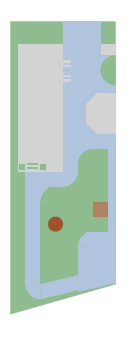

In [25]:
object_collection = dict(
    telek = Polygon([(0, 0), (14, 4), (14, 39), (0, 39)]),
    nagy_gyep = Polygon([(0, 0), (14, 4), (14, 39), (0, 39)], color="#8FBC8F", fill=True),
    kanyar1 = Wedge(2, -90, 0, color="#b0c4de", fill=True),
    kanyar2 = Wedge(2, 180, -90, color="#b0c4de", fill=True),
    kanyar3 = Wedge(2, 90, 180, color="#b0c4de", fill=True),
    ut1 =  Rectangle(2, 5, color="#b0c4de", fill=True),
    ut2 =  Rectangle(5, 2, color="#b0c4de", fill=True),
    ut3 =  Rectangle(2, 4, color="#b0c4de", fill=True),
    ut4 =  Rectangle(3, 2, color="#b0c4de", fill=True),
    ut5 =  Rectangle(3, 2, color="#b0c4de", fill=True),
    ut6 =  Rectangle(2, 12, color="#b0c4de", fill=True),
    ut7 =  Rectangle(3, 2, color="#b0c4de", fill=True),
    ut8 =  Rectangle(1, 13, color="#b0c4de", fill=True),
    kanyar4 = Wedge(2, 90, 180, color="#8FBC8F", fill=True),
    kanyar5 = Wedge(2, 90, 180, color="#8FBC8F", fill=True),
    gyep6 = Rectangle(3, 2, color="#8FBC8F", fill=True),
    haz_elott = Rectangle(7, 12, color="#b0c4de", fill=True),
    haz = Rectangle(6, 12, color="#D3D3D3", fill=True),
    tornac = Rectangle(1, 7, color="#D3D3D3", fill=True),
    lepcso = Polygon([(0, 0), (1, 0), (1, 2.8), (0, 2.8), (0, 2.5), (1, 2.5), (1, 2.2), (0, 2.2), (0, 1.9), (1, 1.9), (1, 0.9), (0, 0.9), (0, 0.6), (1, 0.6), (1, 0.3), (0, 0.3)], color="#D3D3D3", fill=True),
    terasz = CustomPlatform(szines=True, color="#D3D3D3", fill=True),
    tarolo = Rectangle(2, 1.5, color="#D3D3D3", fill=True),
    pavilon = Polygon([(0, 1.5), (0, 4), (4, 4), (4, 0), (1.5, 0)], color="#D3D3D3", fill=True),
    pavilon2 = Polygon([(0, 0), (4, 0), (4, 1.5), (1.5, 1.5)], ls=":", color="#D3D3D3", fill=True),
    kocsi_elol = Rectangle(5, 3, color="#b0c4de", fill=True),
    kocsi_hatul = Polygon([(0, 0), (0, 6), (5, 6), (5, 1.2)], color="#b0c4de", fill=True),
    jarat_hatul = Polygon([(0, 0), (0, 2), (5, 3.2), (5, 1.2)], color="#b0c4de", fill=True),
    diszagyas = Wedge(2, 90, -90, color="#8FBC8F", fill=True),
    mandula = Circle(1, color="#a0522d", fill=True),
    kanyar6 = Wedge(2, -90, 0, color="#8FBC8F", fill=True),
    #platform1 = Rectangle(2, 2, color="red", alpha=0.3, fill=True),
    platform2 = Rectangle(2, 2, color="red", alpha=0.3, fill=True)
)

object_locations = dict(
    telek = (0, 0),
    kanyar1 = (7, 19),
    kanyar2 = (4, 4),
    kanyar3 = (11, 9),
    ut1 = (7, 19),
    ut2 = (2, 17),
    ut3 = (9, 20),
    ut4 = (11, 22),
    ut5 = (2, 15),
    ut6 = (2, 4),
    ut7 = (10, 9),
    ut8 = (13, 9),
    kanyar4 = (11, 20),
    kanyar5 = (6, 15),
    kanyar6 = (6, 7),
    gyep6 = (8, 7),
    haz = (1, 24),
    tornac = (6, 29),
    lepcso = (7, 31),
    terasz = (1, 19),
    tarolo = (12, 34.5),
    pavilon = (10, 24),
    pavilon2 = (10, 28),
    haz_elott = (7, 24),
    kocsi_elol = (7, 36),
    kocsi_hatul = (9, 3),
    jarat_hatul = (4, 2),
    #platform1 = (11, 10),
    platform2 = (11, 13),
    mandula = (6, 12),
    diszagyas = (14, 32.5)
)

for k, v in object_locations.items():
    object_collection[k].update_positions(*v)

fig, ax = plt.subplots(figsize=(2, 6))

ax.set_aspect("equal", adjustable="datalim")
ax.axis('off')
ax.plot([0, 12],[-0.5, -0.5], color="white")

for k, v in object_collection.items():
    v.draw(ax)

fig.savefig("tervek/szabalytalan_gyep.pdf")

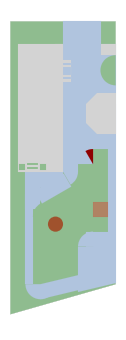

In [55]:
object_collection = dict(
    telek = Polygon([(0, 0), (14, 4), (14, 39), (0, 39)]),
    nagy_gyep = Polygon([(0, 0), (14, 4), (14, 39), (0, 39)], color="#8FBC8F", fill=True),
    kanyar1 = Wedge(2, -60, 0, color="#b0c4de", fill=True),
    kanyar2 = Wedge(2, 180, -30, color="#b0c4de", fill=True),
    kanyar3 = Wedge(2, 90, 180, color="#b0c4de", fill=True),
    ut1 =  Rectangle(2, 5, color="#b0c4de", fill=True),
    ut2 =  Rectangle(5, 2, color="#b0c4de", fill=True),
    ut3 =  Rectangle(2, 4, color="#b0c4de", fill=True),
    ut4 =  Rectangle(3, 2, color="#b0c4de", fill=True),
    ut5 =  Rectangle(2, 3, color="#b0c4de", fill=True),
    ut6 =  Rectangle(1, 12, color="#b0c4de", fill=True),
    ut7 =  Rectangle(3, 2, color="#b0c4de", fill=True),
    ut8 =  Rectangle(1, 13, color="#b0c4de", fill=True),
    ut9 =  Rectangle(2, 4.5, color="#b0c4de", angle=1200, fill=True),
    kanyar4 = Wedge(2, 90, 120, color="#8F0000", fill=True),
    kanyar5 = Wedge(2, 120, 180, color="#8FBC8F", fill=True),
    gyep6 = Rectangle(3, 2, color="#8FBC8F", fill=True),
    haz_elott = Rectangle(7, 12, color="#b0c4de", fill=True),
    haz = Rectangle(6, 12, color="#D3D3D3", fill=True),
    tornac = Rectangle(1, 7, color="#D3D3D3", fill=True),
    lepcso = Polygon([(0, 0), (1, 0), (1, 2.8), (0, 2.8), (0, 2.5), (1, 2.5), (1, 2.2), (0, 2.2), (0, 1.9), (1, 1.9), (1, 0.9), (0, 0.9), (0, 0.6), (1, 0.6), (1, 0.3), (0, 0.3)], color="#D3D3D3", fill=True),
    terasz = CustomPlatform(szines=True, color="#D3D3D3", fill=True),
    tarolo = Rectangle(2, 1.5, color="#D3D3D3", fill=True),
    pavilon = Polygon([(0, 1.5), (0, 4), (4, 4), (4, 0), (1.5, 0)], color="#D3D3D3", fill=True),
    pavilon2 = Polygon([(0, 0), (4, 0), (4, 1.5), (1.5, 1.5)], ls=":", color="#D3D3D3", fill=True),
    kocsi_elol = Rectangle(5, 3, color="#b0c4de", fill=True),
    kocsi_hatul = Polygon([(0, 0), (0, 6), (5, 6), (5, 1.2)], color="#b0c4de", fill=True),
    jarat_hatul = Polygon([(0, 0), (0, 2), (5, 3.2), (5, 1.2)], color="#b0c4de", fill=True),
    diszagyas = Wedge(2, 90, -90, color="#8FBC8F", fill=True),
    mandula = Circle(1, color="#a0522d", fill=True),
    kanyar6 = Wedge(2, -90, 0, color="#8FBC8F", fill=True),
    #platform1 = Rectangle(2, 2, color="red", alpha=0.3, fill=True),
    platform2 = Rectangle(2, 2, color="red", alpha=0.3, fill=True)
)

object_locations = dict(
    telek = (0, 0),
    kanyar1 = (7, 19),
    kanyar2 = (4, 4),
    kanyar3 = (11, 9),
    ut1 = (7, 19),
    ut2 = (2, 17),
    ut3 = (9, 20),
    ut4 = (11, 22),
    ut5 = (2, 14),
    ut6 = (2, 4),
    ut7 = (10, 9),
    ut8 = (13, 9),
    ut9 = (8.1, 17),
    kanyar4 = (11, 20),
    kanyar5 = (5, 13),
    kanyar6 = (6, 7),
    gyep6 = (8, 7),
    haz = (1, 24),
    tornac = (6, 29),
    lepcso = (7, 31),
    terasz = (1, 19),
    tarolo = (12, 34.5),
    pavilon = (10, 24),
    pavilon2 = (10, 28),
    haz_elott = (7, 24),
    kocsi_elol = (7, 36),
    kocsi_hatul = (9, 3),
    jarat_hatul = (4, 2),
    #platform1 = (11, 10),
    platform2 = (11, 13),
    mandula = (6, 12),
    diszagyas = (14, 32.5)
)

for k, v in object_locations.items():
    object_collection[k].update_positions(*v)

fig, ax = plt.subplots(figsize=(2, 6))

ax.set_aspect("equal", adjustable="datalim")
ax.axis('off')
ax.plot([0, 12],[-0.5, -0.5], color="white")

for k, v in object_collection.items():
    v.draw(ax)

#fig.savefig("tervek/kisutak_szintek.pdf")